[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)

# Time travel

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing, re-playing, and even forking from past states. 

We call this `time travel`.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_groq langgraph_sdk langgraph-prebuilt


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

Let's build our agent.

In [3]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGroq(model="openai/gpt-oss-120b", 
                 api_key = os.environ["GROQ_API_KEY"],
                 temperature=0)
llm_with_tools = llm.bind_tools(tools)

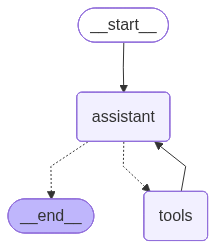

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before.

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_263bb77c-536d-4e29-918b-ab1e51fbb36b)
 Call ID: fc_263bb77c-536d-4e29-918b-ab1e51fbb36b
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

6


## Browsing History

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

In [6]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5d9c59f5-cb37-4a07-85c1-bc0306d6a6cf'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to multiply 2 and 3 using the multiply function.', 'tool_calls': [{'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 209, 'total_tokens': 257, 'completion_time': 0.099487529, 'prompt_time': 0.008422851, 'queue_time': 0.046467379, 'total_time': 0.10791038}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_1d1727abc9', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--30a313fd-84ab-45f8-97e1-3ed449e266fe-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'ty

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [7]:
all_states = [s for s in graph.get_state_history(thread)]

In [8]:
len(all_states)

5

The first element is the current state, just as we got from `get_state`.

In [9]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5d9c59f5-cb37-4a07-85c1-bc0306d6a6cf')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b28b9-ff47-6971-8000-899d8596915d'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-26T16:48:40.228286+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b28b9-ff41-6939-bfff-483995c84eb8'}}, tasks=(PregelTask(id='c3d6a6fc-2e76-9776-e228-7a810cf9f812', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to multiply 2 and 3 using the multiply function.', 'tool_calls': [{'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response

Everything above we can visualize here: 

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying 

We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

Let's look back at the step that recieved human input!

In [10]:
to_replay = all_states[-2]

In [11]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5d9c59f5-cb37-4a07-85c1-bc0306d6a6cf')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b28b9-ff47-6971-8000-899d8596915d'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-26T16:48:40.228286+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b28b9-ff41-6939-bfff-483995c84eb8'}}, tasks=(PregelTask(id='c3d6a6fc-2e76-9776-e228-7a810cf9f812', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to multiply 2 and 3 using the multiply function.', 'tool_calls': [{'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response

Look at the state.

In [12]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5d9c59f5-cb37-4a07-85c1-bc0306d6a6cf')]}

We can see the next node to call.

In [13]:
to_replay.next

('assistant',)

We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.

In [14]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b28b9-ff47-6971-8000-899d8596915d'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed. 

It just re-plays from this checkpoint!

In [15]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_5a1531d8-b934-4e26-a5e6-1fb1a5bd7846)
 Call ID: fc_5a1531d8-b934-4e26-a5e6-1fb1a5bd7846
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

6


Now, we can see our current state after the agent re-ran.

## Forking

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [16]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='5d9c59f5-cb37-4a07-85c1-bc0306d6a6cf')]

Again, we have the config.

In [17]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b28b9-ff47-6971-8000-899d8596915d'}}

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied. 

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [18]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [19]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b28ba-0990-6cbd-8001-0e886c37264e'}}

This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

We can see the current state of our agent has been updated with our fork.

In [20]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5d9c59f5-cb37-4a07-85c1-bc0306d6a6cf'),
 AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to multiply 2 and 3 using the multiply function.', 'tool_calls': [{'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 209, 'total_tokens': 257, 'completion_time': 0.099487529, 'prompt_time': 0.008422851, 'queue_time': 0.046467379, 'total_time': 0.10791038}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_1d1727abc9', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--30a313fd-84ab-45f8-97e1-3ed449e266fe-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'type': 'tool_call'}], usage_metadat

In [21]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5d9c59f5-cb37-4a07-85c1-bc0306d6a6cf'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to multiply 2 and 3 using the multiply function.', 'tool_calls': [{'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 209, 'total_tokens': 257, 'completion_time': 0.099487529, 'prompt_time': 0.008422851, 'queue_time': 0.046467379, 'total_time': 0.10791038}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_1d1727abc9', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--30a313fd-84ab-45f8-97e1-3ed449e266fe-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'ty

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [22]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (fc_263bb77c-536d-4e29-918b-ab1e51fbb36b)
 Call ID: fc_263bb77c-536d-4e29-918b-ab1e51fbb36b
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_4075a85d-bbc8-41de-8bb7-2d5490d9e3a2)
 Call ID: fc_4075a85d-bbc8-41de-8bb7-2d5490d9e3a2
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The product of 5 and 3 is **15**.


Now, we can see the current state is the end of our agent run.

In [23]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='5d9c59f5-cb37-4a07-85c1-bc0306d6a6cf'), AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to multiply 2 and 3 using the multiply function.', 'tool_calls': [{'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 209, 'total_tokens': 257, 'completion_time': 0.099487529, 'prompt_time': 0.008422851, 'queue_time': 0.046467379, 'total_time': 0.10791038}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_1d1727abc9', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--30a313fd-84ab-45f8-97e1-3ed449e266fe-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fc_263bb77c-536d-4e29-918b-ab1e51fbb36b', 'ty

### Time travel with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

We connect to it via the SDK and show how the LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation). 

In [24]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [25]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

#### Re-playing 

Let's run our agent streaming `updates` to the state of the graph after each node is called.

In [26]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'reasoning_content': 'The user wants to multiply 2 and 3. Use the multiply function.', 'tool_calls': [{'id': 'fc_2c8caa2e-fa05-4ac1-bf3f-a42509d2b612', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens': 212, 'total_tokens': 262, 'completion_time': 0.118287745, 'prompt_time': 0.008457521, 'queue_time': 0.052338959, 'total_time': 0.126745266}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_ff6aa7708c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, 'type': 'ai', 'name': None, 'id': 'lc_run--9ab926af-d0b0-4fdf-877d-990c4028e176-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fc_2c8caa2e-fa05-4ac1-bf3f-a42509d2b612', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'in

Now, let's look at **replaying** from a specified checkpoint. 

We simply need to pass the `checkpoint_id`.

In [27]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '9832c10b-c101-43b2-b9c7-7ae9ab839e30'}]},
 'next': ['assistant'],
 'tasks': [{'id': 'fb6845ed-9e13-4406-60d4-70c116e92a56',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'reasoning_content': 'The user wants to multiply 2 and 3. Use the multiply function.',
       'tool_calls': [{'id': 'fc_2c8caa2e-fa05-4ac1-bf3f-a42509d2b612',
         'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
         'type': 'function'}]},
      'response_metadata': {'token_usage': {'completion_tokens': 50,
        'prompt_tokens': 212,
        'total_tokens': 262,
        'completion_time': 0.118287745,
        'prompt_time': 0.008457521,
        'queue_time': 0.0

Let's stream with `stream_mode="values"` to see the full state at every node as we replay. 

In [28]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a216c-1730-750e-8ada-10a70fb1ac25', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '9832c10b-c101-43b2-b9c7-7ae9ab839e30'}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '9832c10b-c101-43b2-b9c7-7ae9ab839e30'}, {'content': '', 'additional_kwargs': {'reasoning_content': 'The user wants to multiply 2 and 3. Use the multiply function.', 'tool_calls': [{'id': 'fc_bef7bb0d-2ab9-4264-8ecc-8612fa716987', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens': 212, 'total_tokens': 262, 'completion_time': 0.107247641, 'prompt_time': 0.008950608, 'queue_time': 0.04

We can all view this as streaming only `updates` to state made by the nodes that we reply.

In [29]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'reasoning_content': 'The user wants to multiply 2 and 3. Use the multiply function.', 'tool_calls': [{'id': 'fc_032e48f4-4077-49f0-8f85-1298d9f39343', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens': 212, 'total_tokens': 262, 'completion_time': 0.105220507, 'prompt_time': 0.008602277, 'queue_time': 0.047005683, 'total_time': 0.113822784}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_fd1fe7f861', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, 'type': 'ai', 'name': None, 'id': 'lc_run--235b0a09-1763-4ad0-99cf-d223015bb792-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fc_032e48f4-4077-49f0-8f85-1298d9f39343', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'in

#### Forking

Now, let's look at forking.

Let's get the same step as we worked with above, the human input.

Let's create a new thread with our agent.

In [30]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'reasoning_content': 'The user wants to multiply 2 and 3. Use the multiply function.', 'tool_calls': [{'id': 'fc_df93ffda-266f-4891-9966-8c982c57272d', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 50, 'prompt_tokens': 212, 'total_tokens': 262, 'completion_time': 0.10450645, 'prompt_time': 0.008109699, 'queue_time': 0.047708511, 'total_time': 0.112616149}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, 'type': 'ai', 'name': None, 'id': 'lc_run--eac1f4ae-aa67-4646-832f-5667ea8a4379-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'fc_df93ffda-266f-4891-9966-8c982c57272d', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'inp

In [31]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': 'ff4cbd85-9870-4368-8026-56dc59e5fd71'}]}

In [32]:
to_fork['values']['messages'][0]['id']

'ff4cbd85-9870-4368-8026-56dc59e5fd71'

In [33]:
to_fork['next']

['assistant']

In [34]:
to_fork['checkpoint_id']

'1f0b28ba-3627-689b-8000-7d8a2cf15993'

Let's edit the state.

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

In [35]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [36]:
forked_config

{'checkpoint': {'thread_id': 'ecf553f9-5778-4e06-afb1-902b19589e9a',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b28ba-3911-6d16-8001-d6cfb93afe58'},
 'configurable': {'thread_id': 'ecf553f9-5778-4e06-afb1-902b19589e9a',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b28ba-3911-6d16-8001-d6cfb93afe58'},
 'checkpoint_id': '1f0b28ba-3911-6d16-8001-d6cfb93afe58'}

In [37]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'ff4cbd85-9870-4368-8026-56dc59e5fd71'},
   {'content': '',
    'additional_kwargs': {'reasoning_content': 'The user wants to multiply 2 and 3. Use the multiply function.',
     'tool_calls': [{'id': 'fc_df93ffda-266f-4891-9966-8c982c57272d',
       'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
       'type': 'function'}]},
    'response_metadata': {'token_usage': {'completion_tokens': 50,
      'prompt_tokens': 212,
      'total_tokens': 262,
      'completion_time': 0.10450645,
      'prompt_time': 0.008109699,
      'queue_time': 0.047708511,
      'total_time': 0.112616149},
     'model_name': 'openai/gpt-oss-120b',
     'system_fingerprint': 'fp_e88ce9c728',
     'service_tier': 'on_demand',
     'finish_reason': 'tool_calls',
     'logprobs': None,
     'model_provider': 'groq'},
    'type': 'ai',
   

To rerun, we pass in the `checkpoint_id`.

In [38]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '65cfa04e-b736-436b-9c74-f23d197672ba', 'tool_call_id': 'fc_df93ffda-266f-4891-9966-8c982c57272d', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'reasoning_content': 'The user asked "Multiply 3 and 3". The assistant incorrectly called multiply with a=2,b=3. Should be a=3,b=3. Need to correct.', 'tool_calls': [{'id': 'fc_b754a9ac-b635-469b-ad47-5460f137fe44', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 63, 'prompt_tokens': 243, 'total_tokens': 306, 'completion_time': 0.130403439, 'prompt_time': 0.009193979, 'queue_time': 0.052753341, 'total_time': 0.139597418}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_ff6aa7708c', 'service_

### LangGraph Studio

Let's look at forking in the Studio UI with our `agent`, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.

As you can see, I am updating (forking) the inputs from '2' and '3' to '5' and '2':

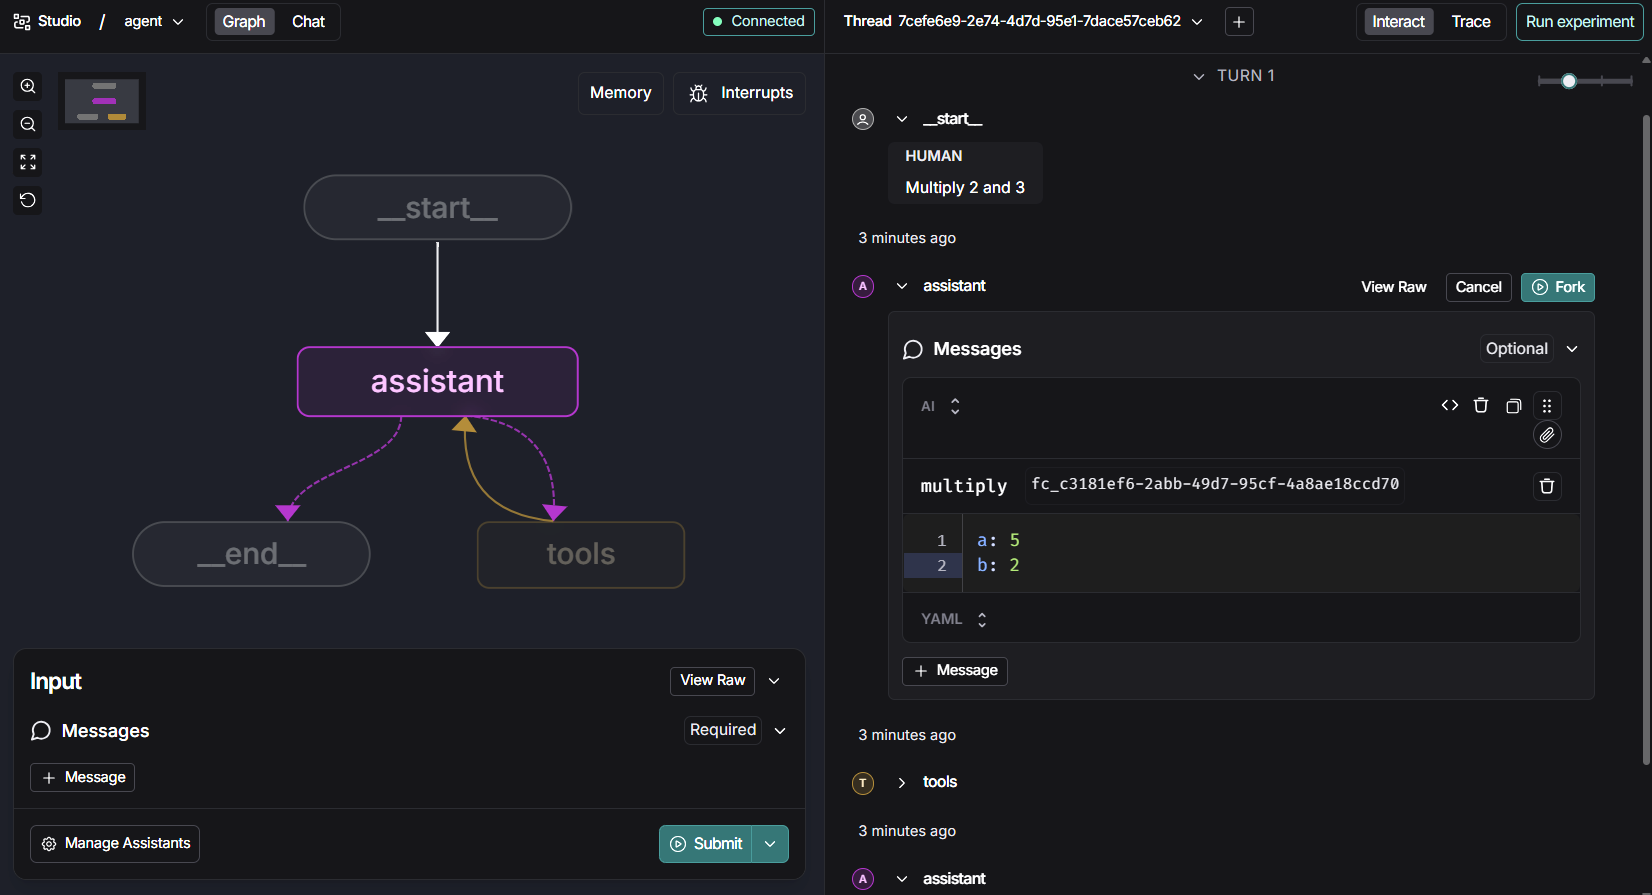

And the tool has updated it's calculation:

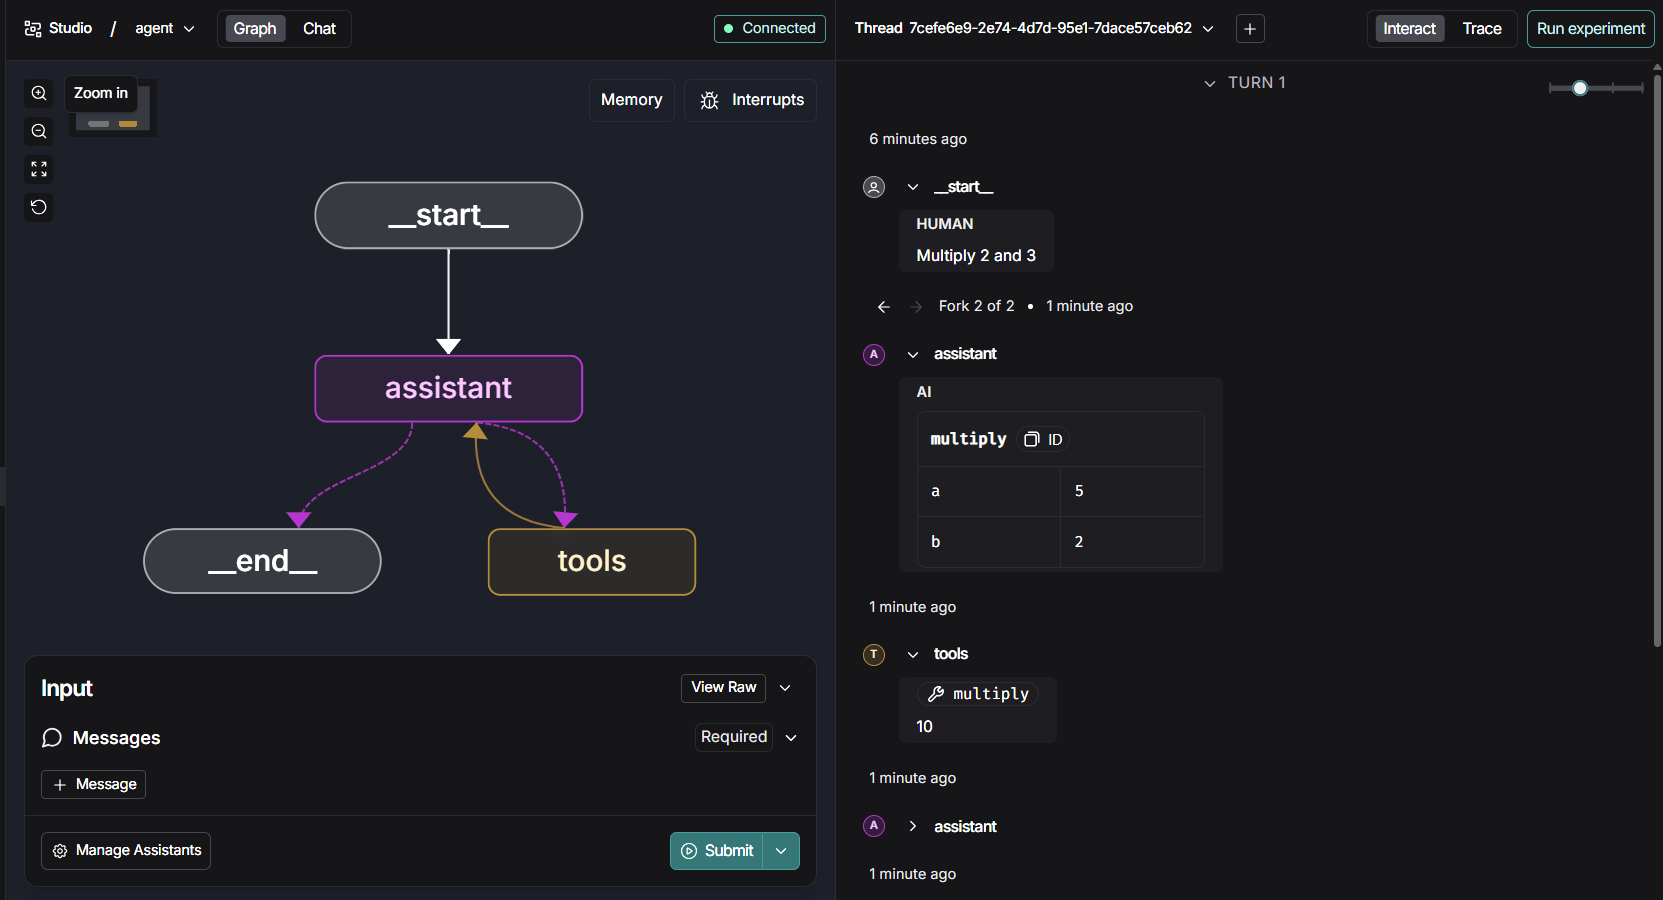

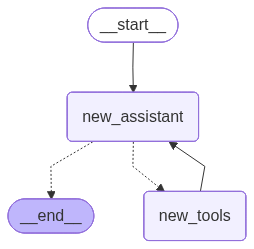

In [39]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def reverse_string(text: str) -> str:
    """Reverses a given string.

    Args:
        text: The input string.
    """
    return text[::-1]

def count_words(text: str) -> int:
    """Counts the number of words in a string.

    Args:
        text: The input string.
    """
    return len(text.split())

def uppercase_string(text: str) -> str:
    """Converts a string to uppercase.

    Args:
        text: The input string.
    """
    return text.upper()

new_tools = [reverse_string, count_words, uppercase_string]
new_llm_with_tools = llm.bind_tools(new_tools)

new_builder = StateGraph(MessagesState)
new_builder.add_node("new_assistant", lambda state: {"messages": [new_llm_with_tools.invoke([sys_msg] + state["messages"])]})
new_builder.add_node("new_tools", ToolNode(new_tools))

new_builder.add_edge(START, "new_assistant")
new_builder.add_conditional_edges(
    "new_assistant",
    lambda state: "new_tools" if tools_condition(state) == "tools" else END,
    {"new_tools": "new_tools", END: END} 
)
new_builder.add_edge("new_tools", "new_assistant")

new_memory = MemorySaver()
new_graph = new_builder.compile(checkpointer=MemorySaver())
display(Image(new_graph.get_graph(xray=True).draw_mermaid_png()))

Execute the graph with an initial input and retrieve the state history.

In [40]:
new_initial_input = {"messages": HumanMessage(content="Reverse the string 'hello'")}
new_thread = {"configurable": {"thread_id": "new_thread_1"}}

print("Streaming execution of the new graph:")
for event in new_graph.stream(new_initial_input, new_thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Retrieve the state history
new_all_states = [s for s in new_graph.get_state_history(new_thread)]
print(f"\nNumber of states in history: {len(new_all_states)}")

Streaming execution of the new graph:
================================ Human Message =================================

Reverse the string 'hello'
================================== Ai Message ==================================
Tool Calls:
  reverse_string (fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13)
 Call ID: fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13
  Args:
    text: hello
================================= Tool Message =================================
Name: reverse_string

olleh
================================== Ai Message ==================================

olleh

Number of states in history: 5


In [41]:
# Print the total number of states
print(f"\nTotal number of states in history: {len(new_all_states)}")

# Access and print the state information for the initial state (last element)
print("\nInitial state:")
display(new_all_states[-1])

# Access and print the state information for an intermediate state (assuming the second to last state is after the initial human message and before the final answer)
print("\nIntermediate state (after assistant's tool call):")
display(new_all_states[-3])


# Access and print the state information for the final state (first element)
print("\nFinal state:")
display(new_all_states[0])

# Print the specific 'messages' value from the initial state
print("\nMessages in the initial state:")
display(new_all_states[-1].values["messages"])


Total number of states in history: 5

Initial state:


StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': 'new_thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b28f7-5b87-6cf2-bfff-5b4aa9b574c3'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-10-26T17:16:07.357771+00:00', parent_config=None, tasks=(PregelTask(id='22919d5b-ab05-8be5-cb6d-4cb5fef8636f', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': HumanMessage(content="Reverse the string 'hello'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d')}),), interrupts=())


Intermediate state (after assistant's tool call):


StateSnapshot(values={'messages': [HumanMessage(content="Reverse the string 'hello'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'), AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id


Final state:


StateSnapshot(values={'messages': [HumanMessage(content="Reverse the string 'hello'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'), AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id


Messages in the initial state:


[]

In [42]:
# Select an intermediate state to replay from (Based on the previous subtask, new_all_states[-3] was the intermediate state after the assistant's tool call)
to_replay_state = new_all_states[-3]
print("State selected for replaying:")
display(to_replay_state)

# Extract the config from the selected state
replay_config = to_replay_state.config
print("\nConfig extracted for replaying:")
display(replay_config)

# Call new_graph.stream with the extracted config and stream_mode="values"
print("\nReplaying graph execution from the selected state:")
for event in new_graph.stream(None, replay_config, stream_mode="values"):
    print(f"\n--- State at step {event.get('metadata', {}).get('step')} ---")
    display(event['messages'])


State selected for replaying:


StateSnapshot(values={'messages': [HumanMessage(content="Reverse the string 'hello'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'), AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id


Config extracted for replaying:


{'configurable': {'thread_id': 'new_thread_1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b28f7-5e15-691d-8001-5cc8c8764b80'}}


Replaying graph execution from the selected state:

--- State at step None ---


[HumanMessage(content="Reverse the string 'hello'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'),
 AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id': 'fc_272b9076-57a0-4b9a-b0b0-c6


--- State at step None ---


[HumanMessage(content="Reverse the string 'hello'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'),
 AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id': 'fc_272b9076-57a0-4b9a-b0b0-c6


--- State at step None ---


[HumanMessage(content="Reverse the string 'hello'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'),
 AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id': 'fc_272b9076-57a0-4b9a-b0b0-c6

In [43]:
# Select a past state to fork from (state containing the initial human message)
# Based on previous runs, new_all_states[-2] is the state right after the initial human message input
to_fork_state = new_all_states[-2]
print("State selected for forking:")
display(to_fork_state)

# Extract the configuration (config) from the selected state
fork_from_config = to_fork_state.config
print("\nConfig extracted for forking:")
display(fork_from_config)

# Define the modified input
original_message_id = to_fork_state.values["messages"][0].id
modified_input_message = HumanMessage(content="Count words in 'this is a test'", id=original_message_id)
modified_input = {"messages": [modified_input_message]}
print("\nModified input message:")
display(modified_input)

# Call new_graph.update_state with the modified input and the checkpoint_id to create a new, forked checkpoint and returns its config
forked_config = new_graph.update_state(
    fork_from_config,
    modified_input,
)
print("\nNew forked config:")
display(forked_config)


# Run the new_graph.stream method using the configuration obtained from update_state
print("\nStreaming graph execution from the forked state:")
for event in new_graph.stream(None, forked_config, stream_mode="values"):
    print(f"\n--- State at step {event.get('metadata', {}).get('step')} ---")
    display(event['messages'])

State selected for forking:


StateSnapshot(values={'messages': [HumanMessage(content="Reverse the string 'hello'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d')]}, next=('new_assistant',), config={'configurable': {'thread_id': 'new_thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b28f7-5b91-6343-8000-7e6be51e1851'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-26T17:16:07.361619+00:00', parent_config={'configurable': {'thread_id': 'new_thread_1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b28f7-5b87-6cf2-bfff-5b4aa9b574c3'}}, tasks=(PregelTask(id='d27c938c-8dbc-0bc1-693a-0252838385c4', name='new_assistant', path=('__pregel_pull', 'new_assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"


Config extracted for forking:


{'configurable': {'thread_id': 'new_thread_1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b28f7-5b91-6343-8000-7e6be51e1851'}}


Modified input message:


{'messages': [HumanMessage(content="Count words in 'this is a test'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d')]}


New forked config:


{'configurable': {'thread_id': 'new_thread_1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b28fd-2460-6438-8001-3bd458ecc5d8'}}


Streaming graph execution from the forked state:

--- State at step None ---


[HumanMessage(content="Count words in 'this is a test'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'),
 AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id': 'fc_272b9076-57a0-4b9a-b0


--- State at step None ---


[HumanMessage(content="Count words in 'this is a test'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'),
 AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id': 'fc_272b9076-57a0-4b9a-b0


--- State at step None ---


[HumanMessage(content="Count words in 'this is a test'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'),
 AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id': 'fc_272b9076-57a0-4b9a-b0


--- State at step None ---


[HumanMessage(content="Count words in 'this is a test'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'),
 AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id': 'fc_272b9076-57a0-4b9a-b0


--- State at step None ---


[HumanMessage(content="Count words in 'this is a test'", additional_kwargs={}, response_metadata={}, id='fa359fd0-6344-4370-a25d-05349933018d'),
 AIMessage(content='', additional_kwargs={'reasoning_content': "The user wants to reverse the string 'hello'. Use the reverse_string function.", 'tool_calls': [{'id': 'fc_272b9076-57a0-4b9a-b0b0-c6e393a66a13', 'function': {'arguments': '{"text":"hello"}', 'name': 'reverse_string'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 201, 'total_tokens': 245, 'completion_time': 0.091906467, 'prompt_time': 0.007902246, 'queue_time': 0.048159774, 'total_time': 0.099808713}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--b4ad95ab-aeaa-42e7-874f-866e4710f7a8-0', tool_calls=[{'name': 'reverse_string', 'args': {'text': 'hello'}, 'id': 'fc_272b9076-57a0-4b9a-b0